## Part 1: Import statements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from collections import Counter

import tensorflow
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D, MaxPooling1D, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D, InputLayer, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.utils import set_random_seed
from tensorflow.data import Dataset


from gensim.models import Word2Vec
import os
import zipfile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
set_random_seed(1)

## Part 2: Importing cleaned data

In [3]:
data = pd.read_csv("Data/processed_data.csv", index_col=0)
data = data.dropna()
data

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1
...,...,...
25291,yous muthafin lie right tl trash mine bible sc...,1
25292,youve gone broke wrong heababy drove redneck c...,2
25294,young buck wan na eat dat nigguh like aint fuc...,1
25295,youu got wild bitches tellin lies,1


In [4]:
number_tweets = len(data["tweet"])
print(f"Number of sentences: {number_tweets}")

Number of sentences: 23865


## Part 3: Splitting Data

In [5]:

#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(data['tweet'], data['class'],  test_size=0.2, random_state=42)

In [6]:
#splitting the data into train and validation
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75, random_state=42)#previously 0.25, 0.75

In [7]:
X_train.sample(5)

13051       man bitch dont call back job cuhh uma snapping
14519    realised library books overdue anyones looking...
10937    like kids beyond scared straight acting like h...
12297                                         winter bitch
18320             somewhere ghetto nigger getting shot bbq
Name: tweet, dtype: object

## Oversampling

In [8]:

def oversample(X_train, y_train):
    print("Before Oversampling: {}".format(Counter(y_train)))

    # # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy='all')

    # # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
    print("After Oversampling: {}".format(Counter(y_train_over)))
    
    return X_train_over, y_train_over

In [9]:
#X_train_tk_over, y_train_over = oversample(X_train_tk, y_train)
X_train_over, y_train_over = oversample(np.array(X_train).reshape(-1,1), y_train)

X_train_over = pd.Series(X_train_over.reshape(len(X_train_over)))


Before Oversampling: Counter({1: 11062, 2: 2437, 0: 820})
After Oversampling: Counter({1: 11062, 2: 11062, 0: 11062})


## Tokenization

In [10]:
tokenizer = Tokenizer()

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train_over)

#encoding training data
encoded_train = tokenizer.texts_to_sequences(X_train_over)
encoded_cv = tokenizer.texts_to_sequences(X_cv)
encoded_test = tokenizer.texts_to_sequences(X_test)

#padding sequences using the maximum sequence of the training set
max_length = max([len(sentence.split()) for sentence in X_train_over])


X_train_tk = pad_sequences(encoded_train,maxlen = max_length, padding = "post" )
X_cv_tk =pad_sequences(encoded_cv,maxlen = max_length, padding = "post" )
X_test_tk =pad_sequences(encoded_test,maxlen = max_length, padding = "post" )

In [12]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

15992

In [11]:
#  encoding target variable
y_train_encoded = to_categorical(y_train_over,3)
y_cv_encoded = to_categorical(y_cv,3)
y_test_encoded = to_categorical(y_test,3)


In [13]:
y_train_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Print Model statistics

In [14]:
def printModelStats(y_preds, y_test):
    print(classification_report(y_test, y_preds, target_names = ['Hate', 'Offensive', 'Neither']))
   
    cm = confusion_matrix(y_test, y_preds)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

In [15]:
def printResults(history):
    results = pd.DataFrame(history.history)
    return results

In [16]:
def plotLossCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.loss)
    plt.plot(results.index, results.val_loss)
    plt.title("CNN model")
    plt.xlabel("Epochs")
    plt.ylabel("Categorical Crossentropy Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [17]:
def plotAccuracyCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.accuracy)
    plt.plot(results.index, results.val_accuracy)
    plt.title("CNN model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.show()

## CNN with custom word embedding

Simple 1D Convolutional neural network to capture the sequence of words 
- inspired by: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [18]:
# #Model 1

num_filters = 64
output_dimension = 100
kernel_size = 5



def createCNN1(num_filters=64,kernel_size=5, output_dimension=100):
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) 
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.01)) (flatten)
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [19]:
model1 = createCNN1(num_filters,kernel_size, output_dimension)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding (Embedding)       (None, 127, 100)          1599200   
                                                                 
 conv1d (Conv1D)             (None, 123, 64)           32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, 61, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3904)              0         
                                                                 
 dense (Dense)               (None, 10)                39050     
                                                             

In [20]:

history = model1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded)) 

Epoch 1/10
519/519 [==============================] - 26s 47ms/step - loss: 0.8126 - accuracy: 0.6068 - val_loss: 0.5697 - val_accuracy: 0.8473
Epoch 2/10
519/519 [==============================] - 26s 49ms/step - loss: 0.4986 - accuracy: 0.7612 - val_loss: 0.4716 - val_accuracy: 0.8552
Epoch 3/10
519/519 [==============================] - 25s 48ms/step - loss: 0.4266 - accuracy: 0.7797 - val_loss: 0.4919 - val_accuracy: 0.8466
Epoch 4/10
519/519 [==============================] - 25s 47ms/step - loss: 0.4020 - accuracy: 0.7862 - val_loss: 0.5086 - val_accuracy: 0.8418
Epoch 5/10
519/519 [==============================] - 25s 47ms/step - loss: 0.3918 - accuracy: 0.7890 - val_loss: 0.4983 - val_accuracy: 0.8435
Epoch 6/10
519/519 [==============================] - 24s 47ms/step - loss: 0.3854 - accuracy: 0.7906 - val_loss: 0.5203 - val_accuracy: 0.8477
Epoch 7/10
519/519 [==============================] - 22s 43ms/step - loss: 0.3778 - accuracy: 0.7903 - val_loss: 0.5364 - val_accuracy:

evaluation

In [21]:
loss,acc = model1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 4ms/step - loss: 0.6406 - accuracy: 0.8320


In [22]:
printResults(history)

,loss,accuracy,val_loss,val_accuracy
0,0.812574,0.606822,0.569658,0.847266
1,0.498582,0.761225,0.471586,0.855227
2,0.426557,0.779696,0.491900,0.846637
3,0.402036,0.786175,0.508598,0.841819
4,0.391775,0.789038,0.498303,0.843495
5,0.385366,0.790635,0.520262,0.847685
6,0.377821,0.790273,0.536399,0.841819
7,0.379475,0.790243,0.541847,0.843285
8,0.377204,0.790152,0.580806,0.841609
9,0.374461,0.790273,0.640626,0.831972


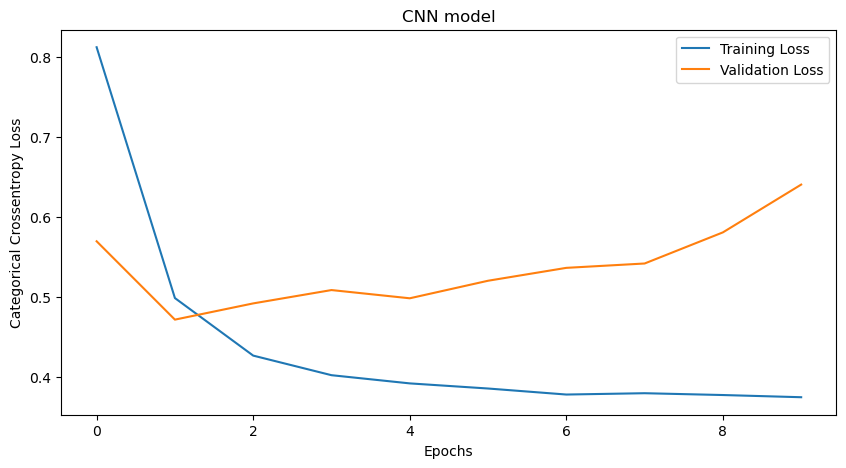

In [23]:
plotLossCurves(history)

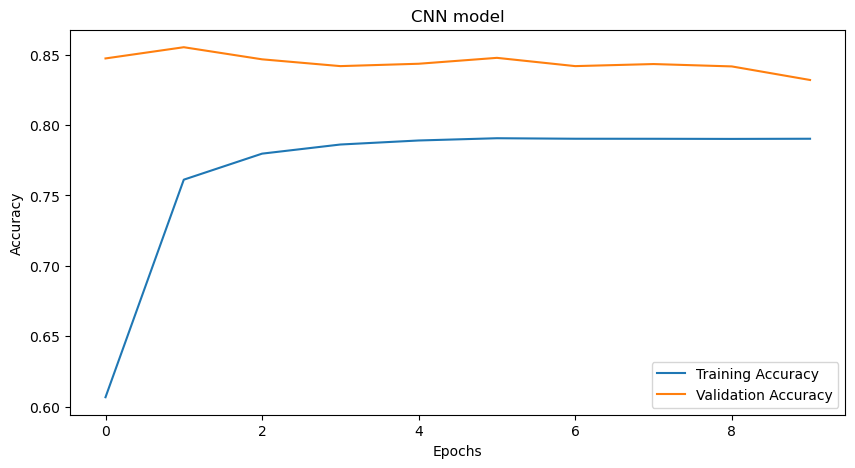

In [24]:
plotAccuracyCurves(history)

150/150 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

        Hate       0.25      0.35      0.29       269
   Offensive       0.90      0.91      0.90      3670
     Neither       0.79      0.66      0.72       834

    accuracy                           0.83      4773
   macro avg       0.65      0.64      0.64      4773
weighted avg       0.84      0.83      0.84      4773

The confusion matrix:
[[  94  152   23]
 [ 217 3330  123]
 [  67  220  547]]


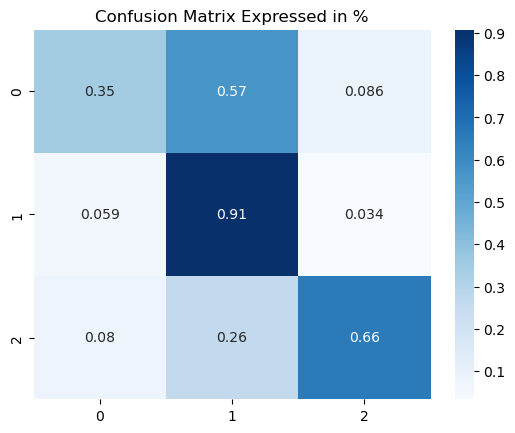

In [25]:
y_pred = model1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)



Trying to see if using callbacks improves the overfitting and thus result

In [26]:
model1_1 = createCNN1(num_filters,kernel_size, output_dimension)
history = model1_1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded), callbacks = callbacks_list) 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 127, 100)          1599200   
                                                                 
 conv1d_1 (Conv1D)           (None, 123, 64)           32064     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 61, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3904)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                39050     
                                                           

In [20]:
printResults(history)

,loss,accuracy,val_loss,val_accuracy
0,0.812574,0.606822,0.569658,0.847266
1,0.498582,0.761225,0.471586,0.855227
2,0.426557,0.779696,0.491900,0.846637
3,0.402036,0.786175,0.508598,0.841819
4,0.391775,0.789038,0.498303,0.843495


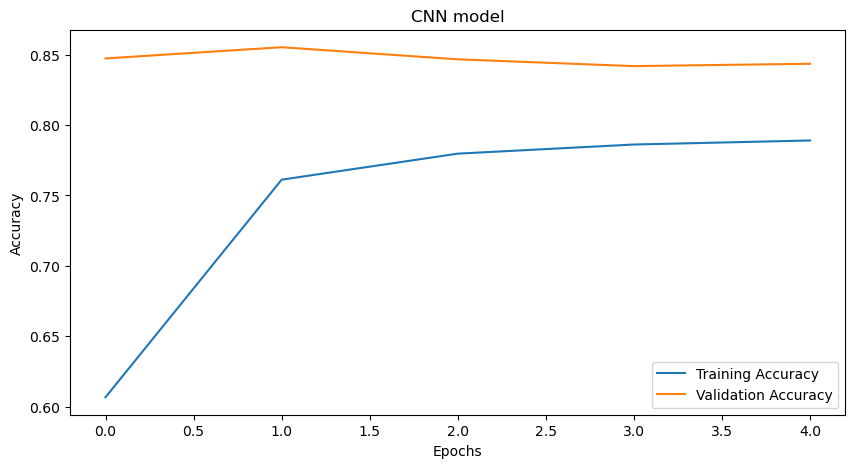

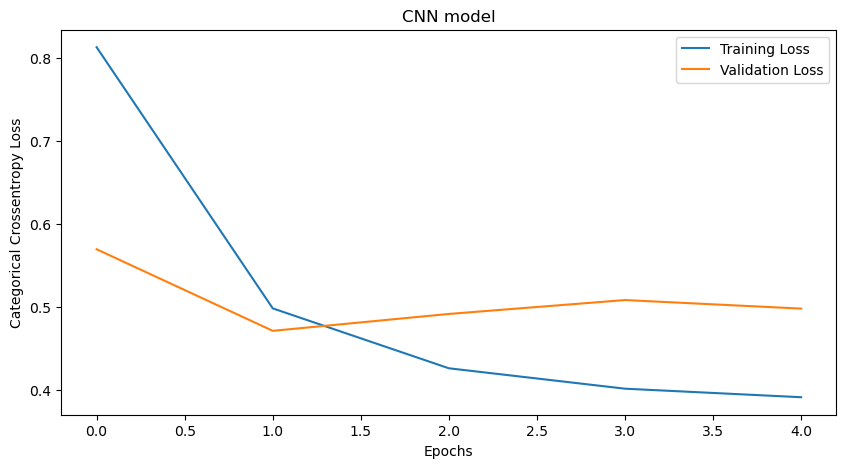

In [21]:
plotAccuracyCurves(history)
plotLossCurves(history)

As shown below the f1 score is the same and the recall for hate actually decreases

150/150 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

        Hate       0.29      0.30      0.29       269
   Offensive       0.89      0.93      0.91      3670
     Neither       0.81      0.63      0.71       834

    accuracy                           0.84      4773
   macro avg       0.66      0.62      0.64      4773
weighted avg       0.84      0.84      0.84      4773

The confusion matrix:
[[  80  167   22]
 [ 151 3418  101]
 [  49  257  528]]


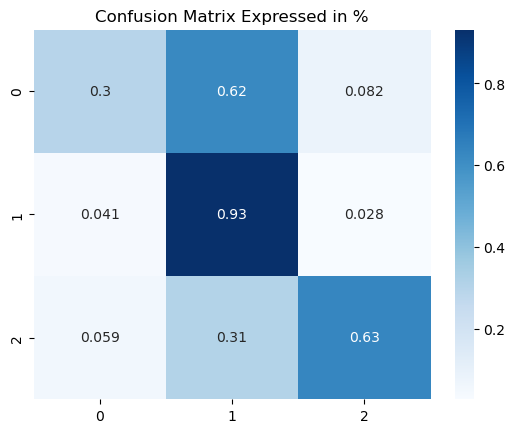

In [22]:
y_pred = model1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)


Test evaluation with self trained embedding and simple CNN

150/150 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

        Hate       0.25      0.33      0.29       280
   Offensive       0.90      0.91      0.90      3715
     Neither       0.79      0.66      0.72       778

    accuracy                           0.83      4773
   macro avg       0.65      0.63      0.64      4773
weighted avg       0.84      0.83      0.84      4773

The confusion matrix:
[[  93  173   14]
 [ 220 3372  123]
 [  53  208  517]]


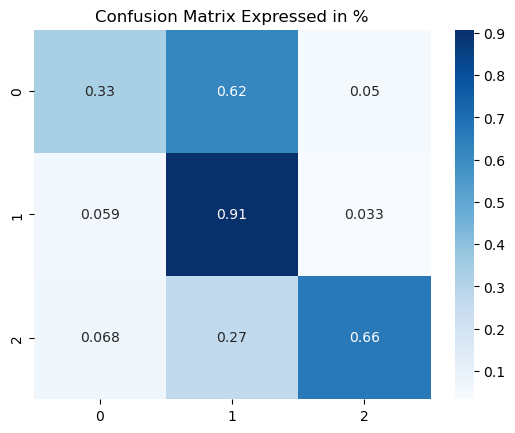

In [27]:
y_pred = model1.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

## Yoon Kim (2014) inspired model 

In Yoon Kim "Convolutional Neural Networks for Sentence Classification", Kim uses a relatively simple CNN for sentence classification and receives great results. Specifically, he uses:
 - embedding dimension of 300 (output_dim)
 - 3 concatenated 1D convolutional layers with kernel sizes of 3,4,5 respectively and ReLu activation
 - 100 filters in each convolutional layer
 - 3 MaxPooling layers
 - A dropout layer of p=0.5
 - L2 regularization with weight of 3

Using some of these parameters an adjusted model was developed and finetuned

Code inspired by:
- https://www.kaggle.com/code/kakiac/deep-learning-4-text-classification-cnn-bi-lstm#CNN-&-Word2Vec-Implementation
- https://www.kaggle.com/code/hamishdickson/cnn-for-sentence-classification-by-yoon-kim#%C2%A0Model-2:-Static-word2vec


In [41]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 100

def createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes):
    
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(0.5))(embedding_layer) # reduced to 0.5 from original 3 since that regularized too much
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)#to prevent overfitting
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2


In [42]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

model2 = createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 127)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 127, 100)             1599200   ['input_6[0][0]']             
                                                                                                  
 conv1d_11 (Conv1D)          (None, 125, 100)             30100     ['embedding_5[0][0]']         
                                                                                                  
 conv1d_12 (Conv1D)          (None, 124, 100)             40100     ['embedding_5[0][0]']         
                                                                                            

In [43]:
history2 = model2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=50, validation_data = (X_cv_tk, y_cv_encoded), callbacks=callbacks_list) # callbacks = callbacks_list


Epoch 1/10


664/664 [==============================] - 65s 96ms/step - loss: 6.5652 - accuracy: 0.5637 - val_loss: 0.7042 - val_accuracy: 0.7641
Epoch 2/10
664/664 [==============================] - 66s 99ms/step - loss: 0.5328 - accuracy: 0.8418 - val_loss: 0.6011 - val_accuracy: 0.8202
Epoch 3/10
664/664 [==============================] - 57s 85ms/step - loss: 0.3699 - accuracy: 0.9111 - val_loss: 0.5226 - val_accuracy: 0.8397
Epoch 4/10
664/664 [==============================] - 65s 98ms/step - loss: 0.2899 - accuracy: 0.9389 - val_loss: 0.5038 - val_accuracy: 0.8517
Epoch 5/10
664/664 [==============================] - 61s 92ms/step - loss: 0.2491 - accuracy: 0.9507 - val_loss: 0.5928 - val_accuracy: 0.8232
Epoch 6/10
664/664 [==============================] - 66s 99ms/step - loss: 0.2198 - accuracy: 0.9602 - val_loss: 0.5307 - val_accuracy: 0.8586
Epoch 7/10
664/664 [==============================] - 67s 101ms/step - loss: 0.1991 - accuracy: 0.9666 - val_loss: 0.5602 - val_accuracy: 0.8408
Ep

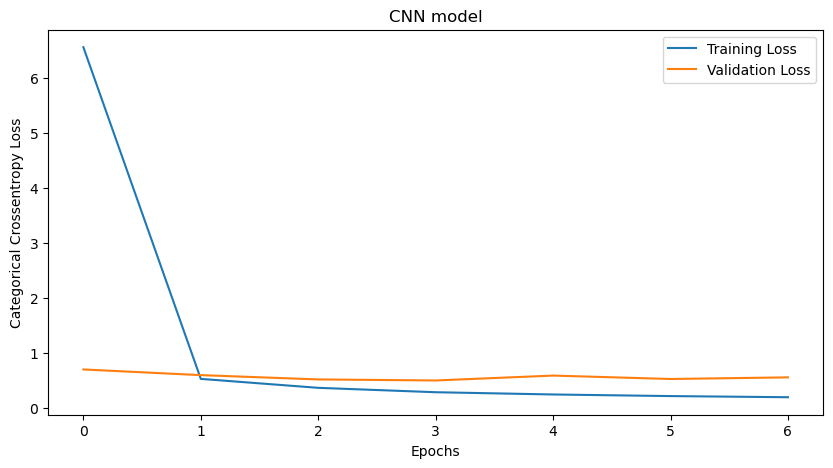

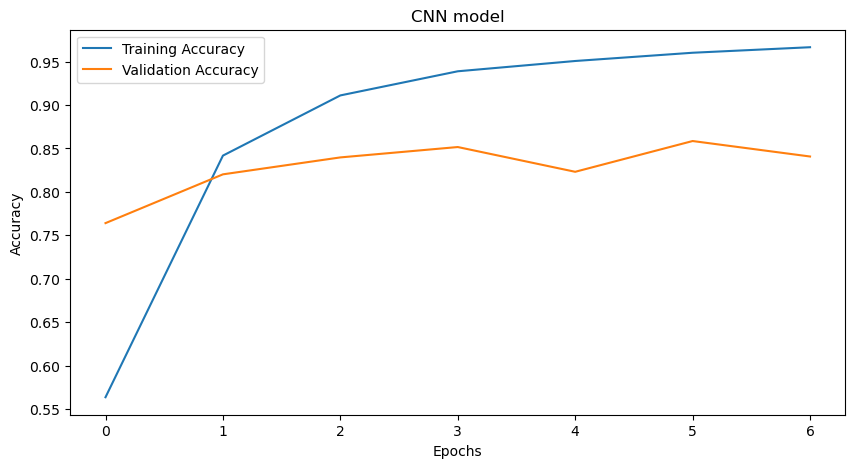

In [44]:
printResults(history2)
plotLossCurves(history2)
plotAccuracyCurves(history2)

150/150 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

        Hate       0.25      0.38      0.30       269
   Offensive       0.93      0.89      0.91      3670
     Neither       0.77      0.79      0.78       834

    accuracy                           0.84      4773
   macro avg       0.65      0.68      0.66      4773
weighted avg       0.86      0.84      0.85      4773

The confusion matrix:
[[ 101  125   43]
 [ 266 3255  149]
 [  40  137  657]]


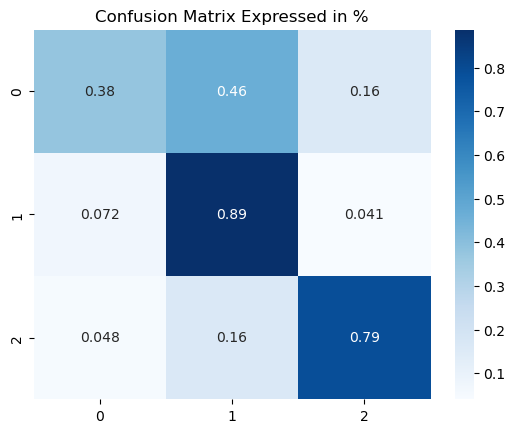

In [45]:
y_pred = model2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

Test evaluation self trained embedding and Kim Yoon inspired model

150/150 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

        Hate       0.28      0.42      0.34       280
   Offensive       0.93      0.89      0.91      3715
     Neither       0.79      0.78      0.78       778

    accuracy                           0.85      4773
   macro avg       0.66      0.70      0.68      4773
weighted avg       0.87      0.85      0.86      4773

The confusion matrix:
[[ 117  138   25]
 [ 255 3321  139]
 [  46  128  604]]


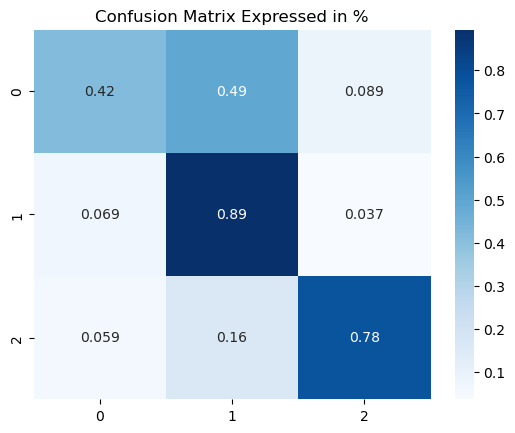

In [47]:
y_pred = model2.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## CNN with pretrained embedding: Word2Vec

- https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#Word2Vec_for_text_classification_example

Creating embedding layer

In [31]:
def createW2Vembedding(dimension, sg):
    #Training Word2Vec embedding layer using Skip grams
    sentences = [sentence.split() for sentence in X_train]
    w2v = Word2Vec(sentences, vector_size = dimension, sg=sg)

    #Creating the embedding weight matrix
    embedding_matrix = np.zeros((vocab_size,dimension))

    for word, i in tokenizer.word_index.items():
     if word in w2v.wv:
            embedding_matrix[i] = w2v.wv[word]

    return embedding_matrix


Simple CNN with word2Vec

In [93]:
def createCNNW2V1(num_filters=64,kernel_size=5, output_dimension=100, sg = 1):

    embedding_matrix = createW2Vembedding(output_dimension,sg)

    #Building model

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length, weights = [embedding_matrix])(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) #pooling to downsample feature extraction
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.05)) (flatten) #increased regularization to prevent overfitting
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.00001) #decreased learning rate to try stabilise validation loss
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [94]:
num_filters = 64
output_dimension = 100
kernel_size = 5
sg = 1

modelW2V1 = createCNNW2V1(num_filters,kernel_size, output_dimension, sg)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 127)]             0         
                                                                 
 embedding_14 (Embedding)    (None, 127, 100)          1599200   
                                                                 
 conv1d_22 (Conv1D)          (None, 123, 64)           32064     
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 61, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 3904)              0         
                                                                 
 dense_24 (Dense)            (None, 10)                39050     
                                                          

In [95]:
history = modelW2V1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded),callbacks=callbacks_list ) #, callbacks=callbacks_list


Epoch 1/10
519/519 [==============================] - 29s 53ms/step - loss: 0.7623 - accuracy: 0.6980 - val_loss: 0.4731 - val_accuracy: 0.8412
Epoch 2/10
519/519 [==============================] - 28s 54ms/step - loss: 0.4089 - accuracy: 0.8822 - val_loss: 0.4736 - val_accuracy: 0.8536
Epoch 3/10
519/519 [==============================] - 33s 65ms/step - loss: 0.2943 - accuracy: 0.9142 - val_loss: 0.6191 - val_accuracy: 0.8089
Epoch 4/10
519/519 [==============================] - 31s 61ms/step - loss: 0.2517 - accuracy: 0.9214 - val_loss: 0.5999 - val_accuracy: 0.8445
Epoch 4: early stopping


In [96]:
loss,acc = modelW2V1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 5ms/step - loss: 0.5999 - accuracy: 0.8445


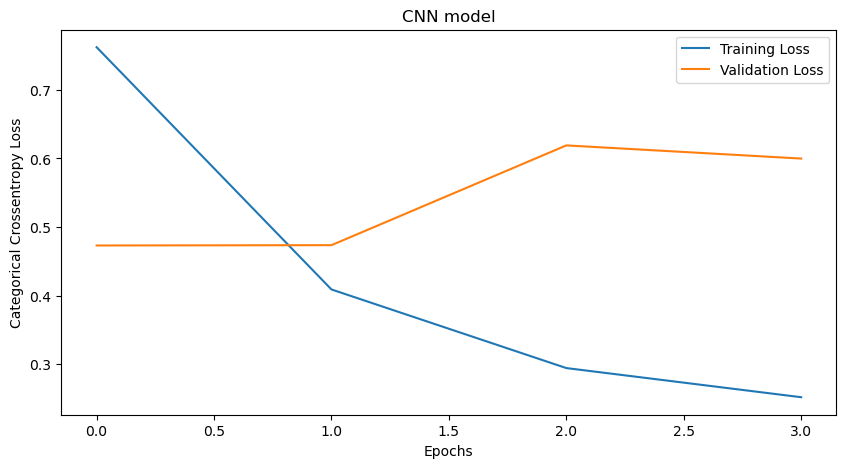

In [97]:
plotLossCurves(history)

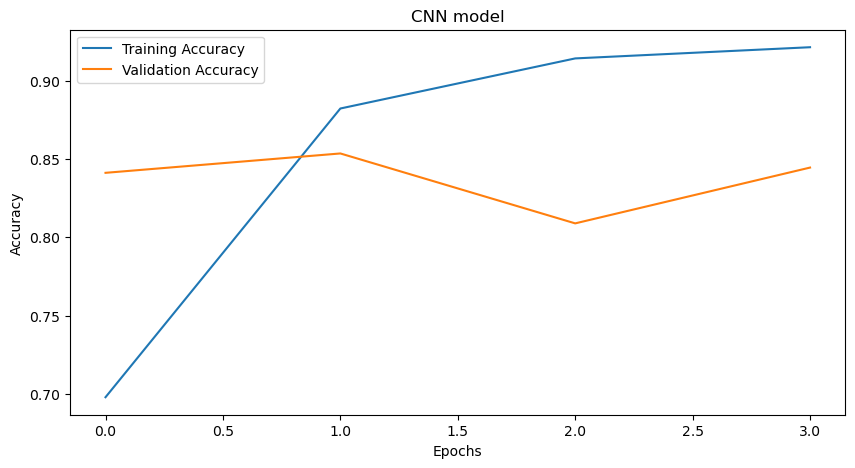

In [98]:
plotAccuracyCurves(history)

150/150 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

        Hate       0.27      0.40      0.32       269
   Offensive       0.92      0.90      0.91      3670
     Neither       0.80      0.73      0.76       834

    accuracy                           0.84      4773
   macro avg       0.66      0.68      0.67      4773
weighted avg       0.86      0.84      0.85      4773

The confusion matrix:
[[ 108  137   24]
 [ 229 3311  130]
 [  61  161  612]]


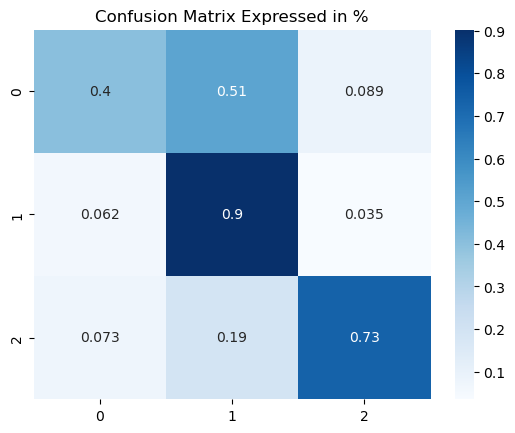

In [99]:
y_pred = modelW2V1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

Test evaluation word2vec embedding with simple cnn

150/150 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

        Hate       0.28      0.41      0.33       280
   Offensive       0.91      0.90      0.91      3715
     Neither       0.79      0.72      0.76       778

    accuracy                           0.84      4773
   macro avg       0.66      0.68      0.67      4773
weighted avg       0.86      0.84      0.85      4773

The confusion matrix:
[[ 115  153   12]
 [ 241 3341  133]
 [  57  159  562]]


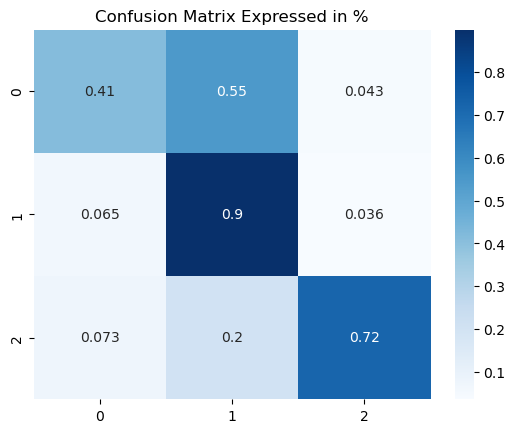

In [101]:
y_pred = modelW2V1.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

Yoon Kim CNN with word2Vec

In [32]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 100

def createCNN2W2V(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, sg):
    embedding_matrix = createW2Vembedding(output_dimension,sg)

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, weights=[embedding_matrix], input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(3))(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)#decreased to 0.0001 from 0.001 for modelw2v2_2
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

modelW2V2 = createCNN2W2V(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, sg=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 127)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 127, 100)             1599200   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 125, 100)             30100     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 124, 100)             40100     ['embedding[0][0]']           
                                                                                              

In [26]:
history2 = modelW2V2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded), callbacks=callbacks_list)


Epoch 1/10
519/519 [==============================] - 64s 119ms/step - loss: 44.3540 - accuracy: 0.5714 - val_loss: 0.7836 - val_accuracy: 0.7599
Epoch 2/10
519/519 [==============================] - 60s 116ms/step - loss: 0.6604 - accuracy: 0.7913 - val_loss: 0.6860 - val_accuracy: 0.8014
Epoch 3/10
519/519 [==============================] - 61s 117ms/step - loss: 0.5396 - accuracy: 0.8555 - val_loss: 0.6421 - val_accuracy: 0.8024
Epoch 4/10
519/519 [==============================] - 63s 121ms/step - loss: 0.4524 - accuracy: 0.9010 - val_loss: 0.6915 - val_accuracy: 0.7876
Epoch 5/10
519/519 [==============================] - 64s 124ms/step - loss: 0.4059 - accuracy: 0.9213 - val_loss: 0.6813 - val_accuracy: 0.8016
Epoch 6/10
519/519 [==============================] - 62s 119ms/step - loss: 0.3679 - accuracy: 0.9339 - val_loss: 0.6280 - val_accuracy: 0.8102
Epoch 7/10
519/519 [==============================] - 61s 117ms/step - loss: 0.3656 - accuracy: 0.9391 - val_loss: 0.6069 - val_a

In [27]:
printResults(history2)


,loss,accuracy,val_loss,val_accuracy
0,44.354038,0.571416,0.783627,0.759899
1,0.660379,0.791328,0.686027,0.801383
2,0.539614,0.855511,0.642060,0.802430
3,0.452378,0.900952,0.691500,0.787555
4,0.405897,0.921322,0.681349,0.801592
5,0.367914,0.933918,0.627987,0.810182
6,0.365627,0.939101,0.606916,0.855646
7,0.343306,0.946001,0.736195,0.805782
8,0.334990,0.950732,0.625319,0.855437
9,0.334479,0.951847,0.642583,0.853761


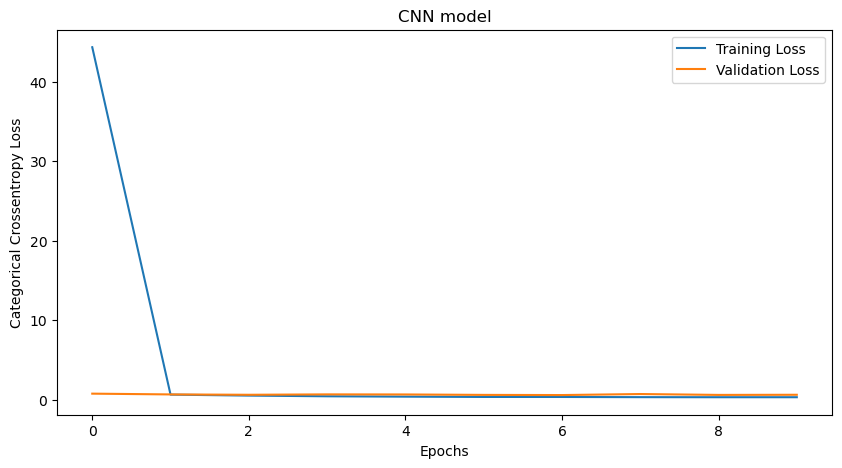

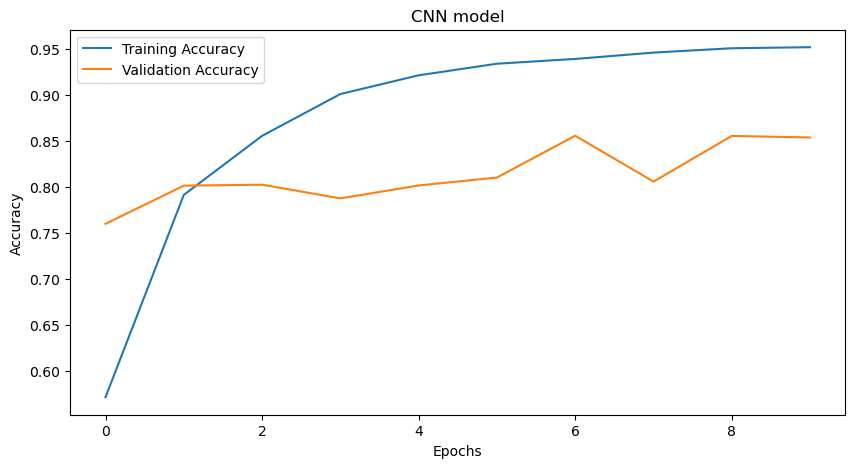

In [28]:
plotLossCurves(history2)
plotAccuracyCurves(history2)

150/150 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

        Hate       0.25      0.33      0.29       269
   Offensive       0.94      0.90      0.92      3670
     Neither       0.77      0.84      0.81       834

    accuracy                           0.85      4773
   macro avg       0.65      0.69      0.67      4773
weighted avg       0.87      0.85      0.86      4773

The confusion matrix:
[[  90  139   40]
 [ 221 3285  164]
 [  51   83  700]]


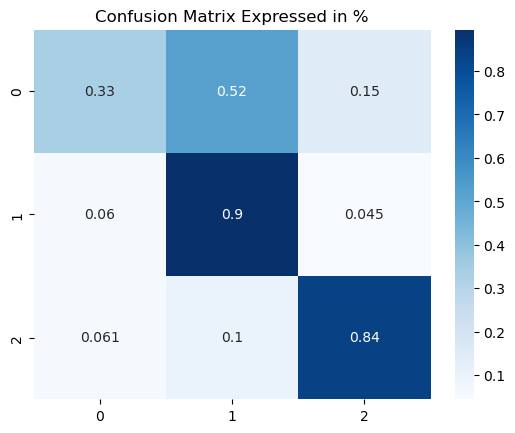

In [29]:
y_pred = modelW2V2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

trying the model again with a slower learning rate

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

modelW2V2_2 = createCNN2W2V(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, sg=1)
modelW2V2_2

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 127)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 127, 100)             1599200   ['input_2[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 125, 100)             30100     ['embedding_1[0][0]']         
                                                                                                  
 conv1d_4 (Conv1D)           (None, 124, 100)             40100     ['embedding_1[0][0]']         
                                                                                            

In [34]:
history3 = modelW2V2_2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded), callbacks=callbacks_list)

Epoch 1/10
519/519 [==============================] - 60s 114ms/step - loss: 44.5297 - accuracy: 0.5625 - val_loss: 0.7642 - val_accuracy: 0.7855
Epoch 2/10
519/519 [==============================] - 62s 119ms/step - loss: 0.6740 - accuracy: 0.7844 - val_loss: 0.7217 - val_accuracy: 0.7777
Epoch 3/10
519/519 [==============================] - 61s 118ms/step - loss: 0.5658 - accuracy: 0.8385 - val_loss: 0.6726 - val_accuracy: 0.7917
Epoch 4/10
519/519 [==============================] - 61s 118ms/step - loss: 0.4799 - accuracy: 0.8858 - val_loss: 0.6585 - val_accuracy: 0.8077
Epoch 5/10
519/519 [==============================] - 62s 119ms/step - loss: 0.4191 - accuracy: 0.9151 - val_loss: 0.6545 - val_accuracy: 0.8104
Epoch 6/10
519/519 [==============================] - 62s 120ms/step - loss: 0.3712 - accuracy: 0.9322 - val_loss: 0.6346 - val_accuracy: 0.8087
Epoch 7/10
519/519 [==============================] - 69s 133ms/step - loss: 0.3663 - accuracy: 0.9383 - val_loss: 0.6536 - val_a

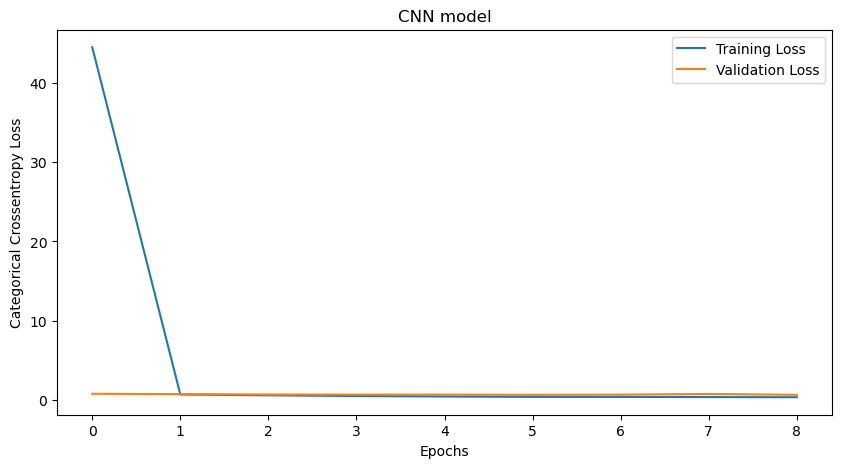

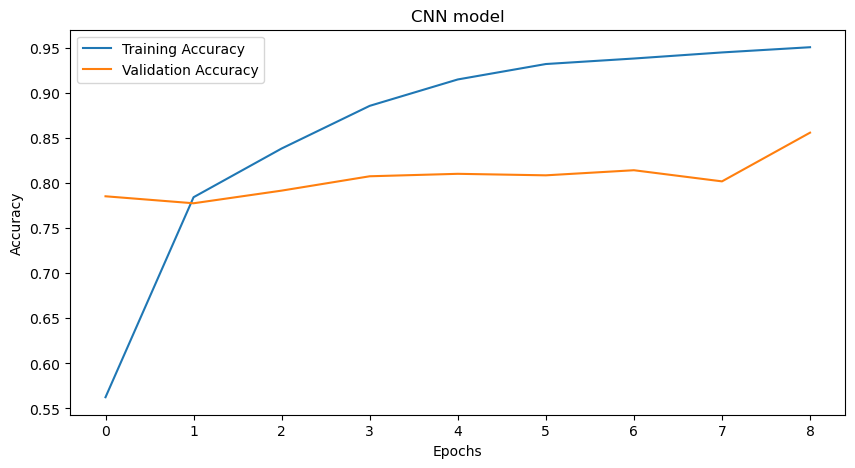

In [35]:
plotLossCurves(history3)
plotAccuracyCurves(history3)

150/150 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

        Hate       0.27      0.33      0.30       269
   Offensive       0.94      0.90      0.92      3670
     Neither       0.75      0.85      0.80       834

    accuracy                           0.86      4773
   macro avg       0.65      0.69      0.67      4773
weighted avg       0.87      0.86      0.86      4773

The confusion matrix:
[[  90  130   49]
 [ 202 3285  183]
 [  43   80  711]]


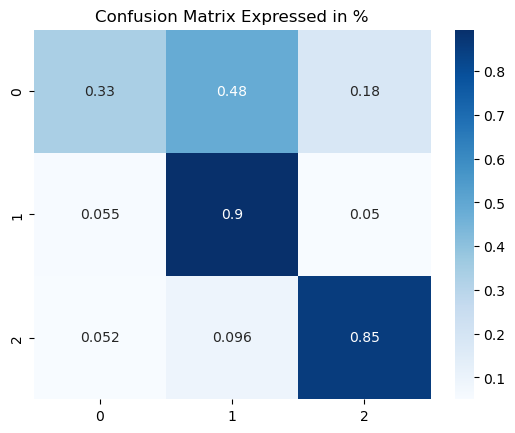

In [36]:
y_pred = modelW2V2_2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

recall is slightly better with a smaller learning rate (0.0001), this will be chosen as the final model for word2vec embedding with kim yoon inspired model

Test evaluation of word2vec embedding with kim yoon inspired model

  1/150 [..............................] - ETA: 8s

150/150 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

        Hate       0.29      0.37      0.32       280
   Offensive       0.94      0.90      0.92      3715
     Neither       0.76      0.85      0.80       778

    accuracy                           0.86      4773
   macro avg       0.66      0.71      0.68      4773
weighted avg       0.87      0.86      0.86      4773

The confusion matrix:
[[ 103  140   37]
 [ 215 3332  168]
 [  36   80  662]]


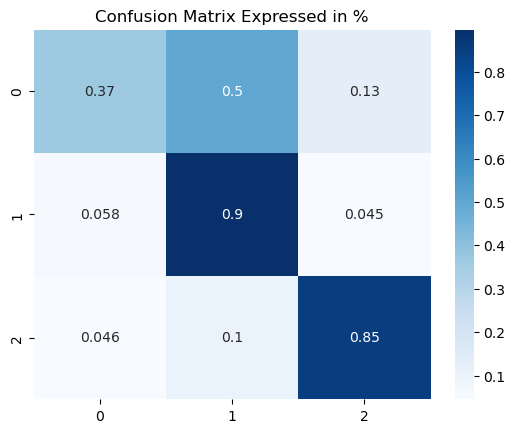

In [37]:
y_pred = modelW2V2_2.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## CNN with pretrained embedding: glove

Opening glove file

In [19]:
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

In [20]:
glove_model = api.load("glove-wiki-gigaword-100")

Create embedding matrix

In [38]:
def createGloveEmbedding(glove_model, dimension):
    embedding_matrix = np.zeros((vocab_size, dimension))

    for word, i in tokenizer.word_index.items():
     
     #trying to find word in glove model
     if word in glove_model:
            embedding_matrix[i] = glove_model[word]

    return embedding_matrix

    

Creating glove embedding

Simple 1D CNN with glove embedding (dimension = 100)

In [22]:
def createCNNGlove1(num_filters=64,kernel_size=8, output_dimension=100):

    embedding_matrix = createGloveEmbedding(glove_model,output_dimension)

    #Building model

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length, weights = [embedding_matrix])(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) #pooling to downsample feature extraction
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.05)) (flatten)
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.00001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [23]:
num_filters = 64
output_dimension = 100
kernel_size = 5


modelGlove1 = createCNNGlove1(num_filters,kernel_size, output_dimension)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding (Embedding)       (None, 127, 100)          1599200   
                                                                 
 conv1d (Conv1D)             (None, 123, 64)           32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, 61, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3904)              0         
                                                                 
 dense (Dense)               (None, 10)                39050     
                                                             

In [24]:
history = modelGlove1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded),callbacks=callbacks_list ) #, callbacks=callbacks_list


Epoch 1/10
519/519 [==============================] - 26s 46ms/step - loss: 0.7352 - accuracy: 0.6956 - val_loss: 0.5120 - val_accuracy: 0.8274
Epoch 2/10
519/519 [==============================] - 24s 45ms/step - loss: 0.4113 - accuracy: 0.8257 - val_loss: 0.4175 - val_accuracy: 0.8693
Epoch 3/10
519/519 [==============================] - 24s 45ms/step - loss: 0.3152 - accuracy: 0.8563 - val_loss: 0.4516 - val_accuracy: 0.8691
Epoch 4/10
519/519 [==============================] - 24s 46ms/step - loss: 0.2777 - accuracy: 0.8639 - val_loss: 0.4982 - val_accuracy: 0.8546
Epoch 5/10
519/519 [==============================] - 24s 47ms/step - loss: 0.2500 - accuracy: 0.8658 - val_loss: 0.4950 - val_accuracy: 0.8621
Epoch 5: early stopping


In [25]:
loss,acc = modelGlove1.evaluate(X_cv_tk, y_cv_encoded)

150/150 [==============================] - 1s 5ms/step - loss: 0.4950 - accuracy: 0.8621


In [26]:
printResults(history)

,loss,accuracy,val_loss,val_accuracy
0,0.735185,0.695564,0.511953,0.827362
1,0.411282,0.825679,0.417500,0.869265
2,0.315155,0.856265,0.451567,0.869055
3,0.277680,0.863888,0.498215,0.854599
4,0.250009,0.865787,0.494985,0.862141


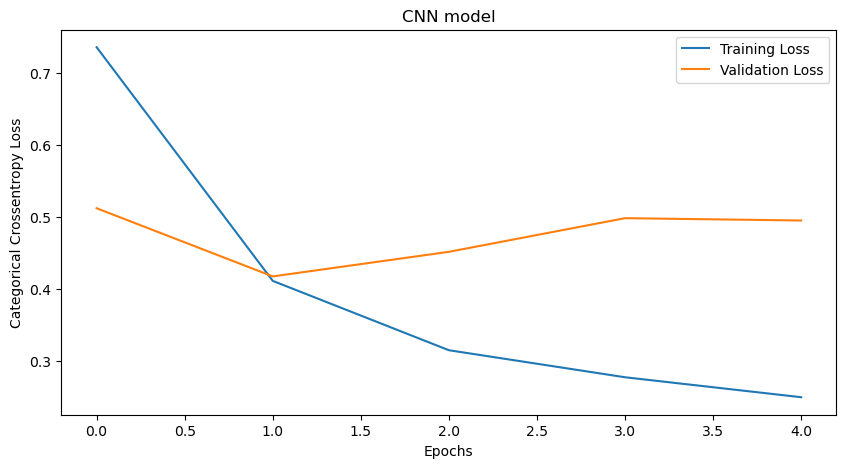

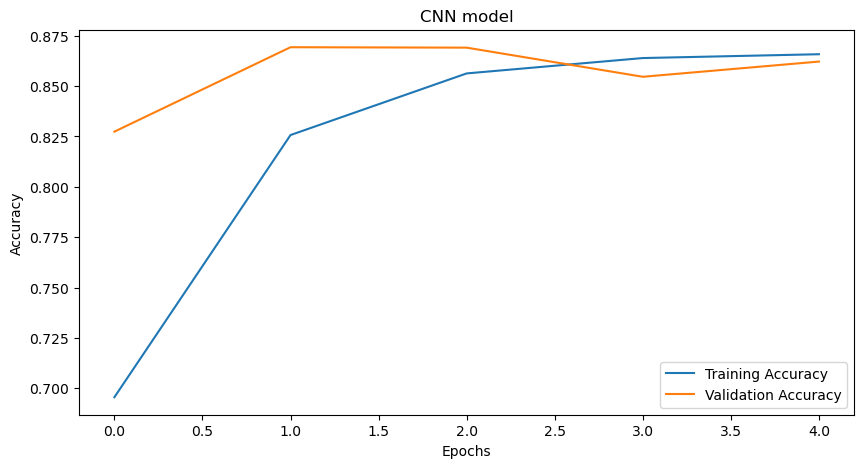

In [27]:
plotLossCurves(history)
plotAccuracyCurves(history)

150/150 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

        Hate       0.31      0.27      0.29       269
   Offensive       0.92      0.91      0.92      3670
     Neither       0.76      0.83      0.79       834

    accuracy                           0.86      4773
   macro avg       0.66      0.67      0.67      4773
weighted avg       0.86      0.86      0.86      4773

The confusion matrix:
[[  72  151   46]
 [ 145 3350  175]
 [  16  125  693]]


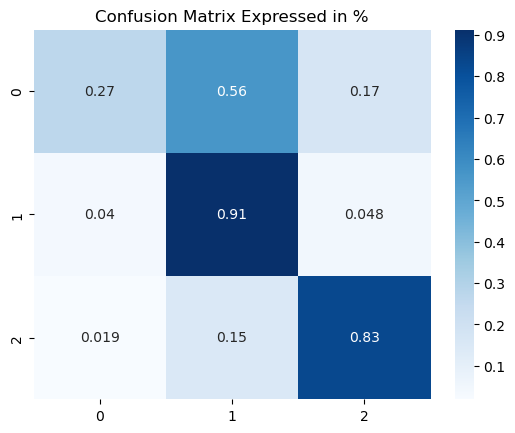

In [28]:
y_pred = modelGlove1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

Final Test evaluation Glove embedding with simple CNN

In [ ]:
y_pred = modelGlove1.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

Yoon Kim model with Glove embedding

In [37]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 100

def createCNNGlove2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes):
    embedding_matrix = createGloveEmbedding(glove_model,output_dimension)

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, weights=[embedding_matrix], input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(3))(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.001)#try making smaller
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

modelGlove2_2 = createCNNGlove2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 127)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 127, 100)             1599200   ['input_3[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 125, 100)             30100     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_5 (Conv1D)           (None, 124, 100)             40100     ['embedding_2[0][0]']         
                                                                                            

In [40]:
history4 = modelGlove2_2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded), callbacks= callbacks_list)


Epoch 1/10
519/519 [==============================] - 61s 115ms/step - loss: 44.0888 - accuracy: 0.5260 - val_loss: 0.9119 - val_accuracy: 0.7700
Epoch 2/10
519/519 [==============================] - 58s 111ms/step - loss: 0.7868 - accuracy: 0.7111 - val_loss: 0.7752 - val_accuracy: 0.7800
Epoch 3/10
519/519 [==============================] - 57s 110ms/step - loss: 0.6676 - accuracy: 0.8177 - val_loss: 0.8533 - val_accuracy: 0.7559
Epoch 4/10
519/519 [==============================] - 58s 111ms/step - loss: 0.5867 - accuracy: 0.8778 - val_loss: 0.7816 - val_accuracy: 0.7993
Epoch 5/10
519/519 [==============================] - 56s 108ms/step - loss: 0.5322 - accuracy: 0.9047 - val_loss: 0.7040 - val_accuracy: 0.8240
Epoch 6/10
519/519 [==============================] - 56s 107ms/step - loss: 0.5017 - accuracy: 0.9203 - val_loss: 0.6616 - val_accuracy: 0.8621
Epoch 7/10
519/519 [==============================] - 57s 109ms/step - loss: 0.4892 - accuracy: 0.9302 - val_loss: 0.6554 - val_a

In [45]:
printResults(history4)

,loss,accuracy,val_loss,val_accuracy
0,44.088760,0.526035,0.911938,0.769956
1,0.786780,0.711083,0.775246,0.780013
2,0.667583,0.817694,0.853281,0.755919
3,0.586737,0.877780,0.781556,0.799288
4,0.532236,0.904689,0.703988,0.824010
5,0.501653,0.920268,0.661625,0.862141
6,0.489230,0.930212,0.655357,0.861303
7,0.460276,0.939493,0.667110,0.854808
8,0.456139,0.943139,0.665835,0.861722


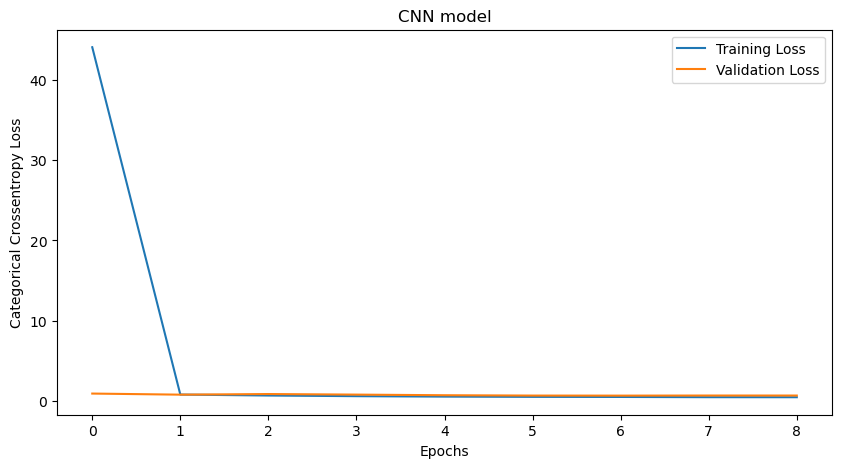

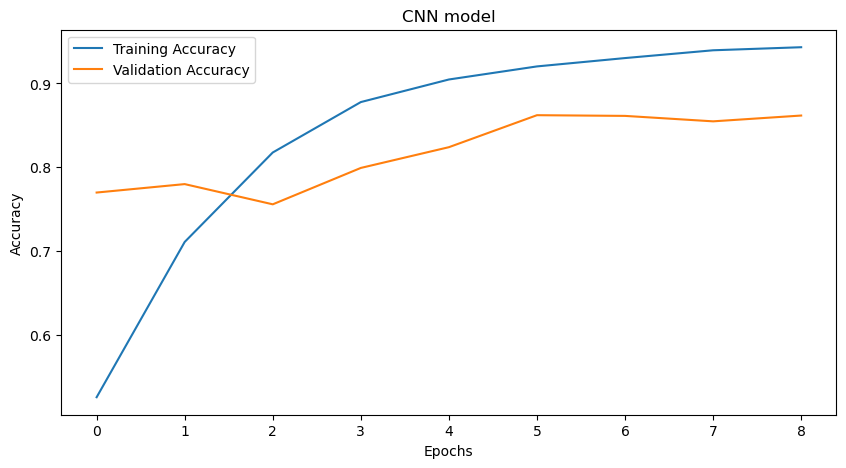

In [46]:
plotLossCurves(history4)
plotAccuracyCurves(history4)

150/150 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

        Hate       0.29      0.42      0.34       269
   Offensive       0.95      0.89      0.92      3670
     Neither       0.78      0.88      0.82       834

    accuracy                           0.86      4773
   macro avg       0.67      0.73      0.69      4773
weighted avg       0.88      0.86      0.87      4773

The confusion matrix:
[[ 112  109   48]
 [ 238 3268  164]
 [  37   64  733]]


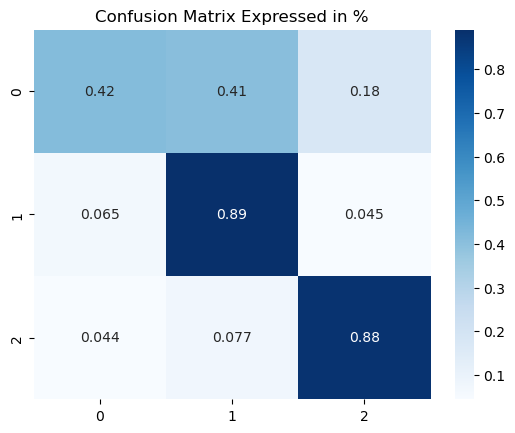

In [47]:
y_pred = modelGlove2_2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

Test evaluation of Glove embedding with kim Yoon inspired model

150/150 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

        Hate       0.35      0.49      0.41       280
   Offensive       0.95      0.90      0.92      3715
     Neither       0.80      0.88      0.84       778

    accuracy                           0.87      4773
   macro avg       0.70      0.75      0.72      4773
weighted avg       0.89      0.87      0.88      4773

The confusion matrix:
[[ 137  120   23]
 [ 233 3331  151]
 [  26   69  683]]


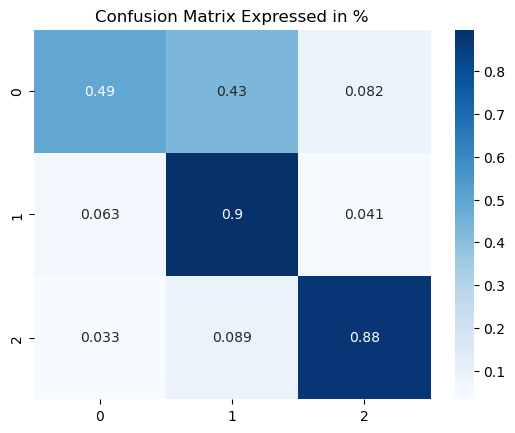

In [42]:
y_pred = modelGlove2_2.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## Parameter search